In [65]:
import pandas as pd
import geopandas as gpd
import fiona
from shapely.geometry import Point, Polygon
import matplotlib.pyplot as plt

import re,os
import numpy as np

import kml2geojson
import json
from util_detroit import kml_to_gpd, csv_with_x_y_to_gpd

pd.options.display.max_columns = None
pd.options.display.max_rows = 200

In [17]:
%load_ext autoreload
%autoreload 2

In [38]:
neighborhood = kml_to_gpd('Current_City_of_Detroit_Neighborhoods')
blight = csv_with_x_y_to_gpd('Blight_Violations.csv')

/var/folders/28/p0bhwx8s3cj150l_wknp1wd80000gp/T/ipykernel_92566/486287638.py:2: DtypeWarning: Columns (9,11,15,16,17,30) have mixed types.Specify dtype option on import or set low_memory=False.
  blight = csv_with_x_y_to_gpd('Blight_Violations.csv')


In [39]:
df = gpd.sjoin(neighborhood.loc[:,['nhood_name','geometry']], blight, how='left', op='intersects')

<AxesSubplot:>

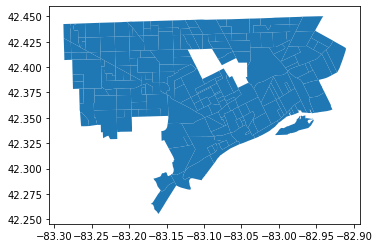

In [46]:
neighborhood.plot()

In [60]:
counts = df.nhood_name.value_counts().to_frame('blight_violations').reset_index().rename(columns={'index':'nhood_name'})

In [ ]:
counts.head()

In [83]:
blight_count_by_neighorhood = neighborhood.merge(counts,on='nhood_name')

[Text(0.5, 1.0, 'Blight Violations')]

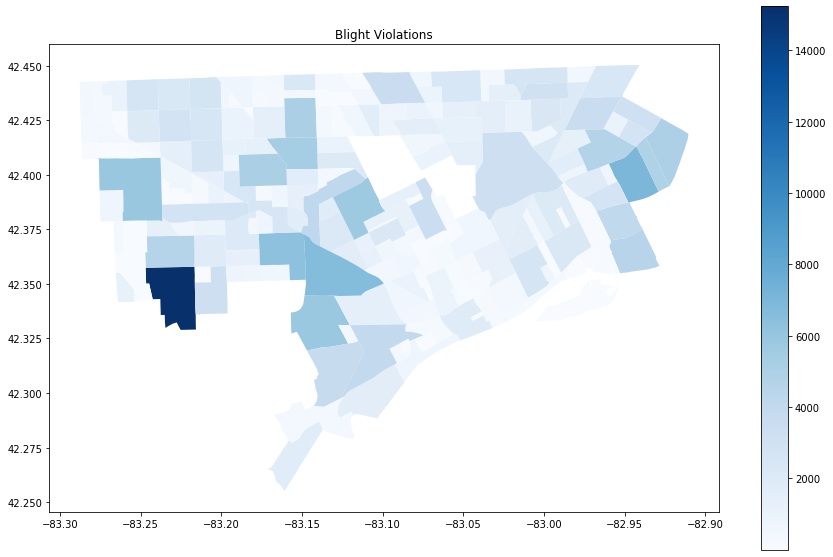

In [84]:
fig, ax = plt.subplots(1,1,figsize=(15,10))
blight_count_by_neighorhood.plot('blight_violations',ax=ax,cmap='Blues',legend=True)
ax.set(title='Blight Violations')